## AOS 453 - Mesoscale Meteorology
## Lab 3 - Lake Effect Snow Simulation
## Instructor: Kelton Halbert
### Assigned: Tuesday, February 26
### Due Date: Friday, March 8 (end of day)
<br>
<br>
In this lab, you will explore some of what you have learned about lake-effect snow storms in a highly idealized 3D amtospheric simulation. The reasoning behind this is that it is often difficult to reliably get a wide array of atmospheric data in three dimensions for a real lake effect snow event. Radar data, while the most prominent, tells us very little about the thermodynamic structure of the atmosphere, but can tell us about precipitation rates and types, and the environmental winds. Radiosondes can tell us about the vertical structure of the surrounding atmosphere as a whole, but doesn't provide insight into the latent fluxes taking place over the lake. Additionally, surface information is hard to come by over the water, save for some ship data that can occasionally be supplemented, albeit spatially scarce. 
<br>
<br>

**Please answer your questions on a seperate write up, and include your figures. In addition to the write up, turn in this lab code in the ipython notebook form.**

<br>
<br>
By running a numerical simulation to attempt to capture an idealized lake-effect snowfall event, we do not have these issues since we are directly solving for every field in 3D. We can also see interesting things such as turbulent heat fluxes, snow mixing ratio concentrations, and even vorticity and divergence. In short, by using the full set of Navier-Stokes equations, we can get a dataset that shows a fuller picture.

## Simulation Configuration
**model**: CM1 version 19.7 <br>
**dx**: 500 m <br>
**dy**: 500 m <br>
**dz**: 50m stretched to 500 m <br>
**width (x)**: 80 km <br>
**width (y)**: 40 km <br>
**depth (z)**: 20 km <br>
<br>
**integration time step**: 5 s <br>
**simulation length**: 5 hours <br>
<br>
**lake fetch**: 48 km <br>
**land fetch**: 32 km <br>
**lake temperature**: 278 deg K <br>
**sounding**: 24 Jan 2007, 00 UTC BUF <br>
<br>
## Lab Overview
Over the course of this lab activity, you will conduct analysis on the observed sounding used to initialize this simulation, analyze the output from CM1 in the form of soundings, plan views, and cross sections, and answer questions about how to interpret the results. You will be re-using code from your Lab 2 assignment, and any new code required will be provided within the code cells below. Where appropriate, please answer questions within a separate write-up document/PDF.

## Part 0: Lab Setup...
Below are the cells necesary for setting up the lab. There is no need to modify this code.

In [1]:
## import the libraries necessary for the lab.
## DO NOT CHANGE!!
import matplotlib.pyplot as plt
import xarray
import numpy as np
import pandas as pd
from datetime import datetime
import metpy
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir
import ipywidgets as widgets
from ipywidgets import interact_manual

We will be re-using the function from Lab 2 that downloads data from the Wyoming Sounding Archive.

In [2]:
## DO NOT CHANGE THIS CODE
def get_sounding_data(station, year, month, day, hour):
    """This function takes an upper air sounding logation and
    integer values for the year, month, day, and hour, and returns 
    the data necessary to plot a sounding. 
    
    ---------------
    Input:
        station: String (e.g. "OUN")
        year: Integer (e.g. 1999)
        month: Integer (e.g. 5)
        day: Integer (e.g. 3)
        hour: Integer (e.g. 18)
    ---------------
    Returns:
        df: Pandas Dataframe
            Contains pressure, temperature, dewpoint, 
            wind speed and wind direction.
    """
    ## date and sounding location to plot.
    date = datetime(year, month, day, hour)
    df = WyomingUpperAir.request_data(date, station)

    ## take the u and v wind components and calculate the
    ## speed and direction instead
    df['u_wind'], df['v_wind'] = mpcalc.wind_components(df['speed'],
                                                        np.deg2rad(df['direction']))

    ## Drop any rows with all NaN values for T, Td, winds
    ## This gets rid of any missing values that might be in
    ## the sounding, making it easier to plot and calculate 
    ## things with.
    df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                           'u_wind', 'v_wind'), how='all').reset_index(drop=True)
    ## returns the dataframe in which the data is stored
    return df



Next, we will read in the data, assign units, and make some calculations on the base data. We are reading in everything except for the last value - this is that the [:-1] means in Python. We are doing this because the last value of the sounding has some missing data... it makes life easier if we just ignore this. Besides, we're interested in what's going down in the lower half of the sounding, so we can get away with it!

In [3]:
data = get_sounding_data("BUF", 2007, 1, 24, 0)

## the -1 means we're ignoring the last value. There was missing data at the top,
## this was the easiest way to get rid of it. 
p = data['pressure'].values[:-1]
h = data['height'].values[:-1]
T = data['temperature'].values[:-1]
Td = data['dewpoint'].values[:-1]
wind_speed = data['speed'].values[:-1]
wind_dir = data['direction'].values[:-1]

## assign units
p = p * units.hPa
h = h * units.meters
T = T * units.degC
Td = Td * units.degC
wind_speed = wind_speed * units.knots
wind_dir = wind_dir * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)
u = u.to('m/s')
v = v.to('m/s')

## calculate some moisture and thermodynamic quantities
rh = mpcalc.relative_humidity_from_dewpoint(T, Td)
mixr = mpcalc.mixing_ratio_from_relative_humidity(rh, T, p)
Tv = mpcalc.virtual_temperature(T, mixr)

## Part 1: Analysis of Initial Environment
In the code cell below, plot a Skew-T/Log-P diagram of the BUF sounding data and answer the following questions. In your plot, create a parcel trace for a surface parcel that is already saturated. That is, when creating your parcel, use `Tv[0]` for both your starting temperature and dewpoint temperature in your `parcel_profile` method. The idea here is that parcels originating from just above the lake will likely be near saturation since the water is warmer than the air. Don't worry about calculating CAPE and CINH - the function doesn't really work well when doing this due to a bug.<br>
Something else that may be helpful is having a height scale on your sounding. Copy and paste this code below your `skew = SkewT(fig, rotation=35)` line: <br>
```python
heights = np.array([1, 2, 3, 4, 5]) * units.km
std_pressures = mpcalc.height_to_pressure_std(heights)
for height_tick, p_tick in zip(heights, std_pressures):
    trans, _, _ = skew.ax.get_yaxis_text1_transform(0)
    skew.ax.text(0.02, p_tick, '---{:~d}'.format(height_tick), transform=trans)```

1. Assuming a primarily west-east oriented lake is positioned just to the west of the sounding, what 3 factors make this enviornment conducive for lake effect snowfall? 
2. Based on your parcel analysis, would there be convection? How deep do you expect for the lake effect convection to be? Does this convection reach the -20C level?
3. Imagine the lake surface acts like a hot plate below the atmosphere, and the inversion is the cold plate. What kind of convection would result if the winds were calm throughout the whole atmosphere? What would its preferred shape be? What convective features/shapes would you expect given the actual wind profile from the sounding? Hint: there's a number that describes this
<br>

/opt/anaconda3/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


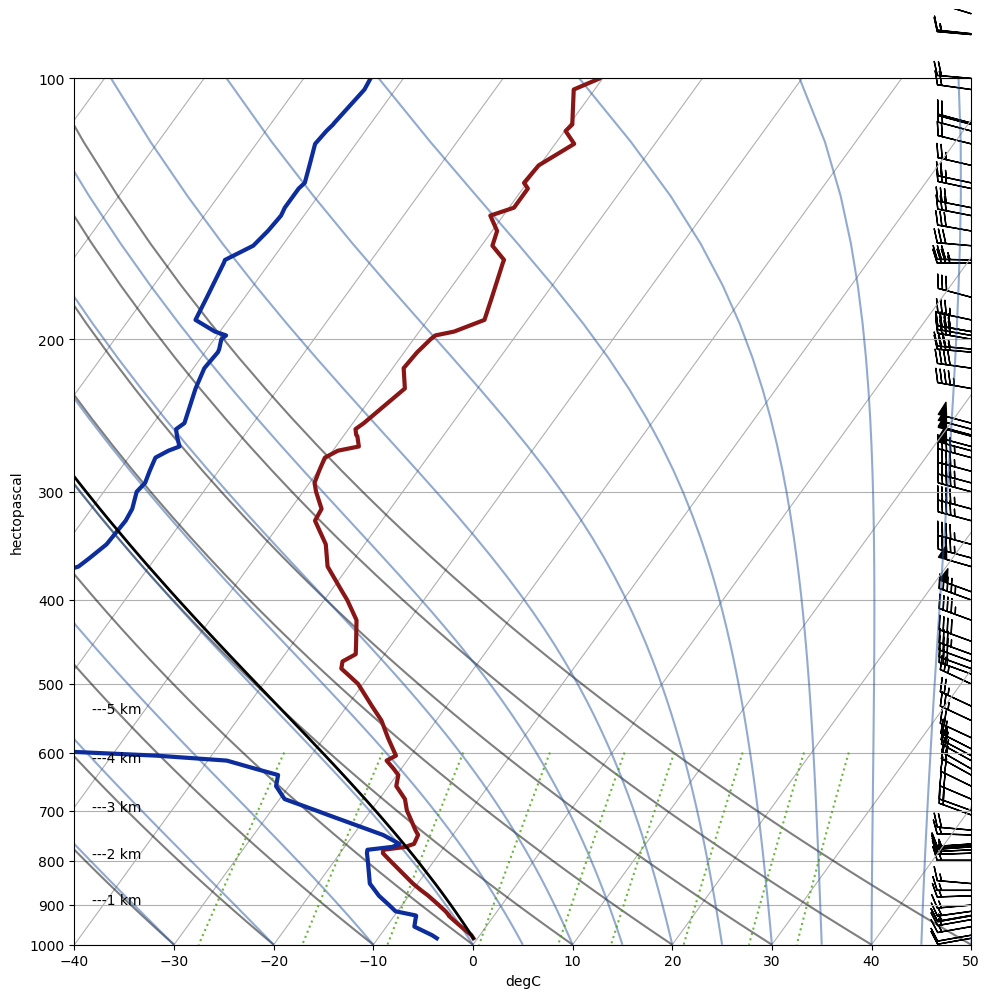

In [4]:
## PUT YOUR SKEW-T CODE HERE!




## Part 2: Analysis of Model Configuration and Basic Plotting
First, we will read in the model data netCDF file and explore what's available by printing its contents. We can access individual variables by calling `cm1data.variables['variable_name']`

In [5]:
## read in the data from the disk - this only needs to be done once
cm1data = xarray.open_dataset("/raid11/aos453data/cm1out_t278K.nc")
## print dataset summary
print("Dataset: ",cm1data)
print("\n")

## print summary of a single variable
print("TSK Variable: ",cm1data.variables['tsk'])
print("\n")

Dataset:  <xarray.Dataset>
Dimensions:   (ni: 160, nip1: 161, nj: 80, njp1: 81, nk: 49, nkp1: 50, one: 1, time: 61)
Coordinates:
  * time      (time) timedelta64[ns] 00:00:00 00:05:00 ... 04:55:00 05:00:00
Dimensions without coordinates: ni, nip1, nj, njp1, nk, nkp1, one
Data variables:
    ztop      (one) float32 ...
    xh        (ni) float32 ...
    xf        (nip1) float32 ...
    yh        (nj) float32 ...
    yf        (njp1) float32 ...
    z         (nk) float32 ...
    zf        (nkp1) float32 ...
    rain      (time, nj, ni) float32 ...
    prate     (time, nj, ni) float32 ...
    sws       (time, nj, ni) float32 ...
    svs       (time, nj, ni) float32 ...
    sps       (time, nj, ni) float32 ...
    srs       (time, nj, ni) float32 ...
    sgs       (time, nj, ni) float32 ...
    sus       (time, nj, ni) float32 ...
    shs       (time, nj, ni) float32 ...
    thflux    (time, nj, ni) float32 ...
    qvflux    (time, nj, ni) float32 ...
    tsk       (time, nj, ni) float32 

#### Lets make a plot of where the lake and land are within our simulation domain. This information is contained within the `xland` variable...

In [6]:
## Print out some information about the variable so
## that we know how to appropriately plot it
print(cm1data.variables['xland'])
print("Array shape: ", cm1data.variables['xland'][:].shape)

<xarray.Variable (time: 61, nj: 80, ni: 160)>
[780800 values with dtype=float32]
Attributes:
    long_name:  land/water flag (1=land,2=water)
    units:      nondimensional
Array shape:  (61, 80, 160)


<br>
Based on this information, we can see that there are 61 time steps, 80 points in the j direction, and 160 points in the i direction. That is, this variable has dimensions time, nj, ni of size (61, 80, 160). This tells us how the data is laid out in memory and how we can access and plot the data. Other variables that contain height information will be of order time, nk, nj, ni.
<br>
<br>

We can get the spatial information of the domain through the `xh`, `yh`, and `z` variables, but they are 1D arrays and must be made into a 2D grid to plot. This is achieved through `np.meshgrid`, which returns 2D position arrays for X and Y values on the cartesian grid. 
The land/water positions arent changing in the simulation because our simulation 'box' doesnt move, so we can just plot the first time in the file. Indexing is done using the `[]` notation.
- `[:]` means all values
- `[a]` means value at index *a*
- `[a:b]` means from a to (but not including) b
- `[a:]` means from a to the end of the array
- `[:b]` means from the beginning of the array to (but not including) b

This can then be done for each dimension in an array, separated by commas. For a 3D array, 
- `[:, :, :]`
- `[a:b, :, :]`
- `[a:, b:, :]`

<br>
With this indexing strategy in mind, we can now plot what the simulation surface looks like.

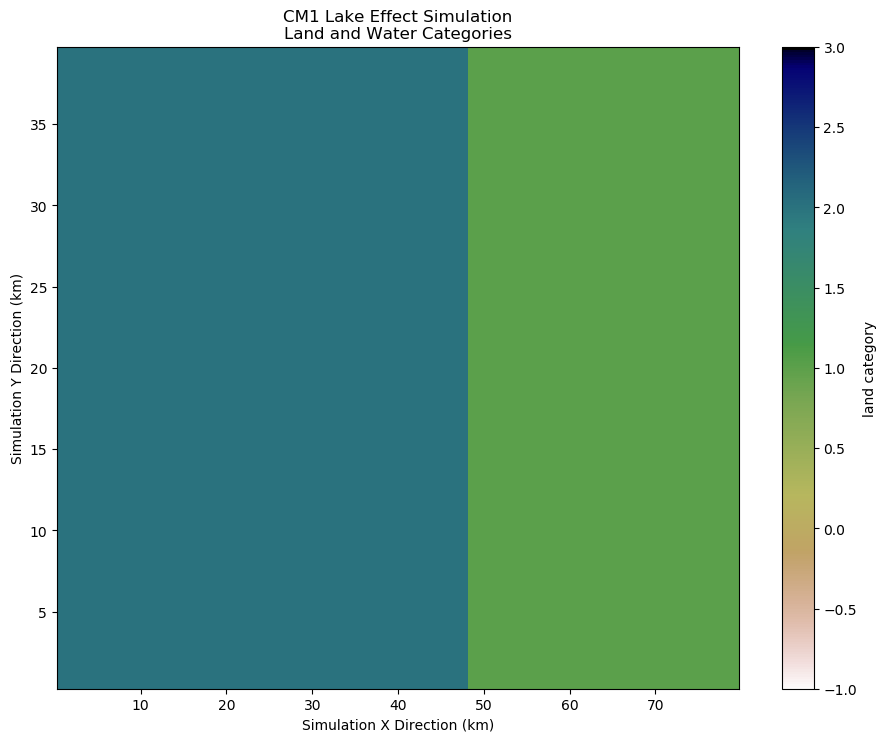

In [7]:
## create the figure we will be plotting on
fig = plt.figure(figsize=(11, 8.5), dpi=100)

## Read in the 1D x, y, and z variables from the model.
## These can be considered like the values of the axes,
## but they still have to be turned into a grid.
xh = cm1data.variables['xh'][:].values
yh = cm1data.variables['yh'][:].values
z = cm1data.variables['z'][:].values

## This takes the 1D x and y arrays and turns them into 2D position arrays for plotting
X, Y = np.meshgrid(xh, yh)

## index just the first time, and then all of the x and y points
xland = cm1data.variables['xland'][0, :, :]


## plot the data as colored cells

## plt.get_cmap('gist_earth_r') gets us the reversed version of the gist_earth colormap. We reverse it 
## because the metadata tells us that 1 is used for land and 2 for water. vmin and vmax are used to scale 
## the color map such that we get blue for water and green for land!
cbar = plt.pcolormesh(X, Y, xland, cmap=plt.get_cmap('gist_earth_r'), vmin=-1, vmax=3)

## Provide plot descriptions through axes annotations and colorbars + labels
plt.title("CM1 Lake Effect Simulation\nLand and Water Categories")
plt.xlabel("Simulation X Direction (km)")
plt.ylabel("Simulation Y Direction (km)")
## add the colorbar
plt.colorbar(cbar,  label='land category')
plt.show()

As you can see, the lake area is plotted in blue, while the land area is plotted in green. The simulation domain was set up such that 60% of the x direction was water, and the remaining 40% was land. This was done so that the primarily westward wind in our sounding had a large enough "fetch" over open water to experience the necessary heat and moisture fluxes to become unstable and produce convection.
<br><br>
Lets do something slightly more interesting now. This only tells us what is land, and what is water - lets take a look at what the difference between the lake/land surface temperature and the 2 meter air temperature above it. This will tell us something about the heat and moisture flux, in a bulk, qualitative sense. We'll also plot streamlines to get a feel for where the wind is blowing.
<br><br>
For future plots, a handy reference of the available colormaps in matplotlib can be found here: https://matplotlib.org/examples/color/colormaps_reference.html

<xarray.Variable (time: 61, nj: 80, ni: 160)>
[780800 values with dtype=float32]
Attributes:
    long_name:  soil/ocean temperature
    units:      K


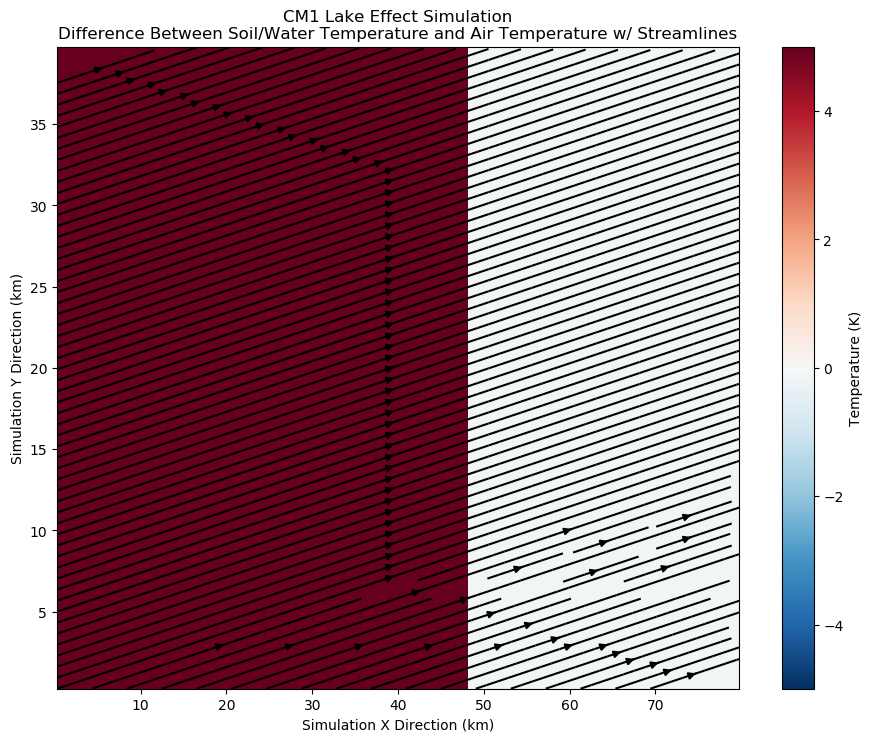

In [14]:
## Create the plotting figure
fig = plt.figure(figsize=(11, 8.5), dpi=100)

## Read in the 1D axes
xh = cm1data.variables['xh'][:].values
yh = cm1data.variables['yh'][:].values
z = cm1data.variables['z'][:].values


## this takes the 1D x and y arrays and turns them into 2D position arrays for plotting
X, Y = np.meshgrid(xh, yh)

## index just the first time, and then all of the x and y points
## tsk is the lower boundary temperature for the simulation, which
## is effectively constant in time. 
print(cm1data.variables['tsk'])
tsk = cm1data.variables['tsk'][0, :, :]

## 2 meter air temperature
t2 = cm1data.variables['t2'][0, :, :]
## get the 10 meter U and V winds
u10 = cm1data.variables['u10'][0, :, :]
v10 = cm1data.variables['v10'][0, :, :]

## compute the difference such that it is positive if the 
## lake is warmer than the air
tdiff = tsk - t2

## plot the data as colored cells
cbar = plt.pcolormesh(X, Y, tdiff, cmap=plt.get_cmap('RdBu_r'), vmin=-5, vmax=5)

## plot some streamlines of the wind - this uses only the 1D arrays for reasons...
plt.streamplot(xh, yh, u10, v10, color='k', density=2)

## Provide plot descriptions through axes annotations and colorbars + labels
plt.title("CM1 Lake Effect Simulation\nDifference Between Soil/Water Temperature and Air Temperature w/ Streamlines")
plt.xlabel("Simulation X Direction (km)")
plt.ylabel("Simulation Y Direction (km)")
## add the colorbar
plt.colorbar(cbar,  label='Temperature (K)')
plt.show()

Alright, so admittedly, this isn't terribly exciting either, but now you can see how drastic the temperature difference between the lake and the air is in the simulation. The air temperature above the lake is much colder than the lake itself, while the air above the ground is roughly the same temperature as the ground surface, which is what drives this whole lake effect snow process. I'm doing this to show you the simplicity of how this model simulation is set up.  All we've done to get the data we're about to analyze is:
1. Pick an atmospheric sounding
2. Prescribe where there is water and where there is land
3. Prescribe a static temperature for soil and lake

After that, we just hit run, and let the atmosphere do its thing. ***No other forcing is used to get convection***. I'll also take time to note here that there is no change in elevation between the water and the land. While in real life, there is often a gentle slope upward as you leave the water, this simulation treats everything as a flat slab. In reality, the terrain slope can help enhance convergence of air, but the change in surface from water to land accomplishes this well enough. 
<br><br>
The last thing we'll do to hammer home some of these plotting techniques is show you something interesting. Below is a plot of model reflectivity above the ground at approximately 1km, with vertical velocity colored in red (negative values are dashed by default). Additionally, we will make the streamlines vary their width based on the wind speed. The thicker the line, the faster the wind speed. This will allow for you to see both directional and speed convergence.

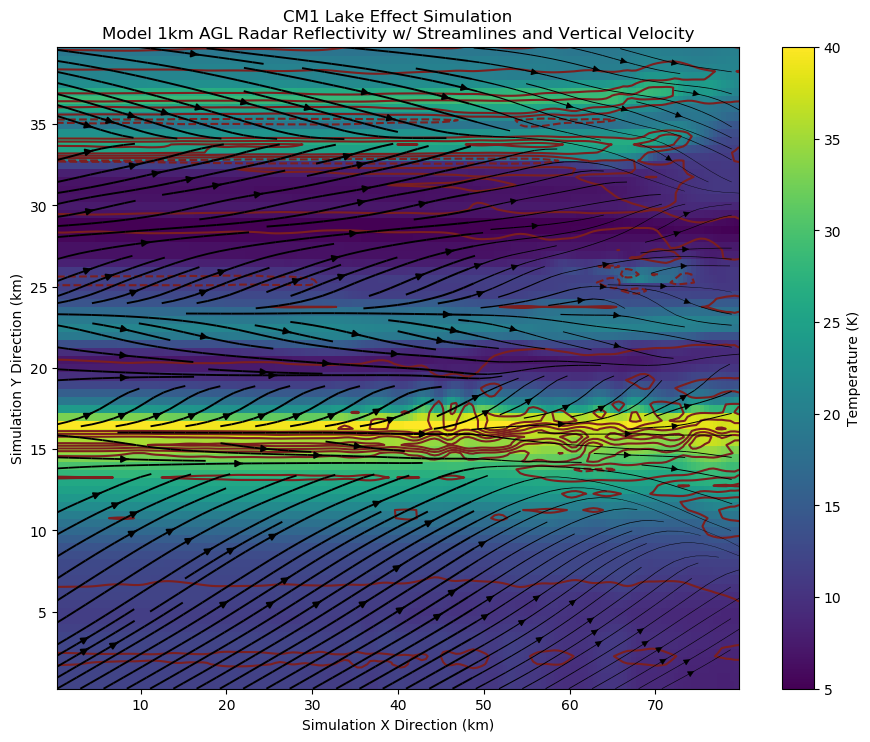

In [15]:
## Create the plot figure
fig = plt.figure(figsize=(11, 8.5), dpi=100)

## Read in the 1D position arrays
xh = cm1data.variables['xh'][:].values
yh = cm1data.variables['yh'][:].values
z = cm1data.variables['z'][:].values


## this takes the 1D x and y arrays and turns them into 2D position arrays for plotting
X, Y = np.meshgrid(xh, yh)

## index the last time, the 8th level above ground (about 1km), and then all of the x and y points
## the data is laid out as [time, z, y, x]
dbz = cm1data.variables['dbz'][-1, 8, :, :]
winterp = cm1data.variables['winterp'][-1, 8, :, :]
## get the 10 meter U and V winds
u10 = cm1data.variables['u10'][-1, :, :]
v10 = cm1data.variables['v10'][-1, :, :]
## compute the wind speed 
speed = np.sqrt(u10.values**2 + v10.values**2)

## plot the data as colored cells
cbar = plt.pcolormesh(X, Y, dbz, cmap=plt.get_cmap('viridis'), vmin=5, vmax=40)
plt.contour(X, Y, winterp, levels=np.arange(-2.5, 2.5, .5), colors='#7c1f1f')

## plot some streamlines of the wind with the line widths scaled by the speed
lw = 1.5*speed / speed.max()
plt.streamplot(xh, yh, u10, v10, color='k', density=2, linewidth=lw)

## Provide plot descriptions through axes annotations and colorbars + labels
plt.title("CM1 Lake Effect Simulation\nModel 1km AGL Radar Reflectivity w/ Streamlines and Vertical Velocity")
plt.xlabel("Simulation X Direction (km)")
plt.ylabel("Simulation Y Direction (km)")
## add the colorbar
plt.colorbar(cbar,  label='Temperature (K)')
plt.show()
plt.savefig("reflectivity.png")

What you're seeing in this image is the last frame of the model simulation. The plotted field, reflectivity, reveals a singular, dominant band of high reflectivity that represents the snowfall. With the surface winds, you can see that the field has been drastically modified from its base state to have both directional and speed convergence. From left to right, you can see the winds go from fast over the water, to slow over land, and take on directional components that are influenced by the convection over the lake.
<br>
## Part 3: Cross Section Analysis
In the last code example, you saw how to take a 2D X/Y slice of dBZ by specifying a single height level (in this case, 8 for ~1km level). In the next section, you will conduct Y/Z cross sections through an X plane, meaning your x index will be a static number. That is to say, you will index array structured as (time, nz, ny, nx) as `[time_index, :, :, x_index]` instead of what was done above. I have already filled in the necessary `meshgrid` function for the Y/Z cross section axes.
<br><br>
The change between lake and land happens at index 95, so you may use that as your x index, i.e. `[time_index, :, :, 95]` for accessing data for your cross section.
<br>
#### Cross Section Plot
1. Create a Y-Z cross section of the snow mixing ratio, potential temperature, and velocity field at the last time step. That means you can use time_index = -1.
 - The snow mixing ratio is stored under the variable __[`qs`]__, which is the unitless mixing ratio. If you multiply it by 1000, it then has units of grams of snow/kg of air. Do this so that you can make your pcolormesh __[`vmin = 0`]__ and __[`vmax = 1`]__. Once you have multiplied by 1000, you can plot with pcolormesh.
 - Read in the uinterp, vinterp, and winterp variables (which have 4 indices just like the snow mixing ratio). Multiply winterp by 10 - this has the effect of scaling it to cm/s, which is better for displaying the winds. In the examples above, we used streamlines to show the winds. However, since our vertical grid doesn't have constant spacing, we can't use it. Instead, you may use the __[`quiver`]__ function to plot the winds. You may copy this line into your code: __[`plt.quiver(Y, Z, vinterp, winterp, color=my_color)`]__ with an appropriate value of my_color.
 - Read in the potential temperature array, which is stored under the name __[`th`]__. Use the contour function to plot the potential temperature surfaces at these surfaces: __`[levels=np.arange(265, 400, 5)]`__.
 - Restrict your plot area so that the features of interest are more visible. Set __[`plt.ylim(0,8)`]__ to set the valid range from 0 km to 8 km instead of the default 20 km.
2. What is the relationship between the maximum vertical velocity and the surface convergence from the radar reflectivity figure above? How does the vertical velocity relate to the maximum snow concentration in your cross section?
3. Why are the rises in the theta surfaces related to the maximum in precipitation? What sort of response do you see in the theta and wind field due to the presence of the convection? Hint: this is a type of wave.
4. How deep is the simulated convection in comparison to your surface parcel trace from above? If there is a difference, why might that be?

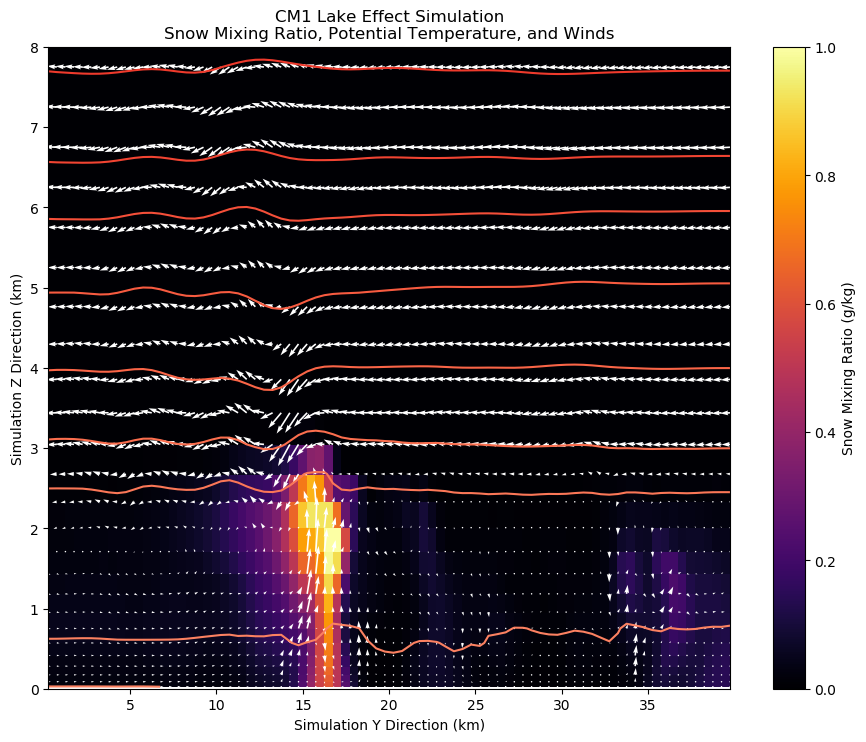

In [10]:
fig = plt.figure(figsize=(11, 8.5), dpi=100)

xh = cm1data.variables['xh'][:].values
yh = cm1data.variables['yh'][:].values
z = cm1data.variables['z'][:].values


## this takes the 1D x and y arrays and turns them into 2D position arrays for plotting
Y, Z = np.meshgrid(yh, z)


## YOUR CODE GOES HERE




plt.title("CM1 Lake Effect Simulation\nSnow Mixing Ratio, Potential Temperature, and Winds")
plt.xlabel("Simulation Y Direction (km)")
plt.ylabel("Simulation Z Direction (km)")
## add the colorbar
plt.ylim(0,8)
plt.colorbar(cbar,  label='Snow Mixing Ratio (g/kg)')
plt.show()
plt.savefig("qc-cross-section.png")

## Part 4: Develop a Rule of Thumb
Now that we have an idealized simulation that encompasses somewhat realistic lake effect snow, what can we potentially learn from it? In this section, we're going to derive a simple rule of thumb that we can apply to sounding parcel analysis to assist in forecasting these phenomena. We will do this by plotting the potential temperature perturbation at the surface.
<br>
If you recall from linearization theory, you can break up a field into its base state and perturbations from that base state: $\theta = \bar{\theta} + \theta'$
<br>
In CM1, $\bar{\theta}$ is the potential temperature from your input sounding at some height, i.e. it is only a function of z. This makes $\theta'$ the perturbation from the initial sounding, which is useful in that it can tell us by how much a particular level has been warmed.
<br><br>
### Make an X-Y Plot of Potential Temperature Perturbation
The potential temperature perturbation field is stored in the dataset as `thpert`, and is a 4D array of order `[ntimes, nk, nj, ni]` just like our other variables. 
- Read in __`[thpert]`__ and plot it for the last time in the file (tindex = -1) and for the first level above ground (zindex = 0). Make a pcolormesh plot that is symmetric about zero, i.e. vmin=-a and vmax=a. Pick a colormap that is symmetric as well.
- Read in the __`[u10]`__ and __`[v10]`__ variables and plot the streamlines as earlier, varying the line widths based on speed. You can just copy and paste the code if needed.
- Change the plot description to have the appropriate units (Kelvin)

<br>
What you should get is a plot of the potential temperature perturbation with the surface streamlines on top. You should see that the perturbation is near zero where the precipitation is falling, negative over the land, and warm over the lake.
<br>
<br>

1. By about how much does the lake warm the air immediately above the surface? Is this more than expected, or less? Take note of this number. We will use it to modify our parcel trace for our rule of thumb.
2. Why is the perturbation lower where there is precipitation? What is the role of the convection in restoring balance?
3. This particular simulation was run for ~5 hours of simulation time. If I ran it indefinitely, how long would it take for the lake effect snow to stop? Think about our model setup...
4. Based on  your answer to (3), would the real atmosphere be able to sustain this? How long can lake effect snowstorms last in reality?



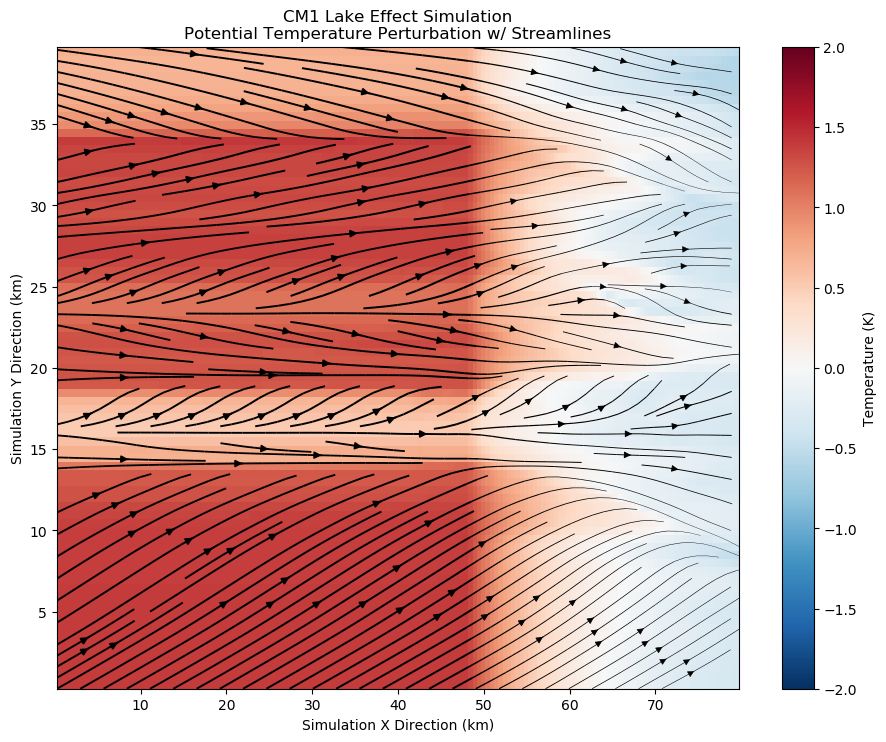

In [11]:
fig = plt.figure(figsize=(11, 8.5), dpi=100)

xh = cm1data.variables['xh'][:].values
yh = cm1data.variables['yh'][:].values
z = cm1data.variables['z'][:].values


## this takes the 1D x and y arrays and turns them into 2D position arrays for plotting
X, Y = np.meshgrid(xh, yh)

## YOUR CODE GOES HERE


## Provide plot descriptions through axes annotations and colorbars + labels
plt.title("CM1 Lake Effect Simulation\nPotential Temperature Perturbation w/ Streamlines")
plt.xlabel("Simulation X Direction (km)")
plt.ylabel("Simulation Y Direction (km)")
## add the colorbar
plt.colorbar(cbar,  label='Temperature (K)')
plt.show()
plt.savefig("thpert.png")

In the cell below, put in your value for the perturbation temperature that you answered above. We will modify our surface parcel with this value and see how it changes the parcel trace.

In [16]:
## change this value from 0!
tpert = 0 * units.degK

## Part 4: I Promise It's Finally Over...
No more coding - I've done the rest for you. If you run this cell, you will see a set of sliders below. This will allow for you to select  X and Y locations at some time T. Additionally, if you ran the cell above, the surface parcel trace will be modified to include the heating of the air above the water. I have plotted in the background in a thinner line, the original observed BUF sounding for comparison.
<br>
<br>
Mess around with some of the soundings over space and time to get a feel for how the simulation evolves. Then answer the following questions.
<br>

1. Set the time slider to 0 and pick a location in the domain. When initializing the simulation with a sounding, the interpolations do not always match up. How different is the observed sounding from the starting simulation sounding? Do these differences appear to be significant enough to throw out this simulation?
2. Having applied our rule of thumb to the surface parcel, how does the estimate for the depth of the convection change? Does it match the actual convective depth better or worse?
3. Look at profiles towards the end of the simulation. What is the net effect of the convection on the environment? What happens to the inversion layer? What happens to the low level lapse rates and moisture?

In [18]:
def plot_skewt(tidx, xidx, yidx):
    th = cm1data.variables['th'][tidx, :, yidx, xidx].values * units.degK
    qv = cm1data.variables['qv'][tidx, :, yidx, xidx].values * units.dimensionless
    p2 = cm1data.variables['prs'][tidx, :, yidx, xidx].values /100. * units.hPa
    T2 = mpcalc.temperature_from_potential_temperature(p2, th)
    spech = mpcalc.specific_humidity_from_mixing_ratio(qv)
    Td2 = mpcalc.dewpoint_from_specific_humidity(spech, T2, p2)
    Tv2 = mpcalc.virtual_temperature(T2, qv)
    ## create the figure on which we will draw.
    fig = plt.figure(figsize=(10, 10), dpi=100)
    ## turn that otherwise rectangular figure into
    ## somethign with skewed axes
    skew = SkewT(fig, rotation=35)
    heights = np.array([1, 2, 3, 4, 5]) * units.km
    std_pressures = mpcalc.height_to_pressure_std(heights)
    for height_tick, p_tick in zip(heights, std_pressures):
        trans, _, _ = skew.ax.get_yaxis_text1_transform(0)
        skew.ax.text(0.02, p_tick, '---{:~d}'.format(height_tick), transform=trans)

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, Tv.to('degC'), '#891616', linewidth=1.0)
    skew.plot(p, Td, '#0c2d9b', linewidth=1.0)
    skew.plot(p2, Tv2.to('degC'), '#891616', linewidth=3.0)
    skew.plot(p2, Td2, '#0c2d9b', linewidth=3.0)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)

    ## Calculate full parcel profile and add to plot as black line.
    ## This is done by calling mpcalc.parcel_profile with the full
    ## array of pressure, and then the surface temperature and dewpoint.


    ## This will return data about the parcel temperature in degrees kelvin,
    ## so we convert it to celsius before plotting it.
    surface_parcel = mpcalc.parcel_profile(p, Tv2[0]+tpert, Tv2[0]+tpert).to('degC')
    skew.plot(p, surface_parcel, 'k', linewidth=2)


    ## Add the relevant special lines

    ## Make the dry adiabats black with colors='k', specify them
    ## as solid
    skew.plot_dry_adiabats(colors='k', linestyles='solid')
    ## Solid line with specific color
    skew.plot_moist_adiabats(linestyles='solid', colors="#27569e")
    ## dotted line with specific color
    skew.plot_mixing_lines(linestyles='dotted', colors="#4ba013")


    # Show the plot
    plt.tight_layout()
    plt.show()
    
# Finally, call the plotting function and show the map interactively
interact_manual(plot_skewt,
                tidx=widgets.IntSlider(min=0, max=60, step=1, value=0,
                                             description='Time Index'),
                xidx=widgets.IntSlider(min=0, max=159, step=1, value=0,
                                             description='X Index'),
                yidx=widgets.IntSlider(min=0, max=79, step=1, value=0,
                                              description='Y Index'))

interactive(children=(IntSlider(value=0, description='Time Index', max=60), IntSlider(value=0, description='X …

<function __main__.plot_skewt(tidx, xidx, yidx)>